- 본 사전 프로젝트의 목적은 W컨셉에서 제안한 상품의 브랜드, 종류, 사용목적(남, 녀, 홈, 뷰티), 가격에 따른 소비자의 관심 여부를 구별해 내는 것에 있다.

In [1]:
# requirement

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter('ignore')


In [2]:
wconcept_df = pd.read_csv("wconcept.csv")

In [3]:
len(wconcept_df)

3791

In [4]:
for i in wconcept_df.columns:
    wconcept_df["{}".format(i)] = wconcept_df["{}".format(
        i)].replace("", np.nan)

In [5]:
wconcept_df.isnull().sum()

urls                0
malls               0
gender              0
products            0
brands              0
normal_prices    1550
sale_prices         0
stars               0
make_dates         16
dtype: int64

In [6]:
wconcept_df = wconcept_df.drop(
    ["urls", "malls", "normal_prices", "make_dates"], axis=1)
wconcept_df = wconcept_df.dropna(axis=0)

In [7]:
wconcept_df.head(2)

,gender,products,brands,sale_prices,stars
0,LIFE,양말,POSITIVE.V,"14,400",5.0
1,LIFE,양말,POSITIVE.V,"12,800",0.0


In [8]:
wconcept_df["products"] = wconcept_df["products"].replace("HOODIES", "HOODIE")

- 데이터 선정 (하나에 브랜드(brands) 및 하나의 종류(products) 별 50개 이상의 데이터를 가진 항목만 최종 분석에 사용하였다.)

In [9]:
price_list = wconcept_df.sale_prices.values.tolist()

    - 브랜드 별 50개 이하 데이터를 가진 항목(행) 삭제

In [10]:
wconcept_df["count"] = 1
pro_b = wconcept_df.groupby(["brands"])["count"].sum()
pro_b = pro_b.sort_values(ascending=False)

In [11]:
delete_brand = []
for i in range(0, len(pro_b)):
    if pro_b[i] < 50:
        brand = pro_b.index[i]
        delete_brand.append(brand)

In [12]:
for word in delete_brand:
    wconcept_df["brands"] = wconcept_df["brands"].replace(
        "{}".format(word), np.nan)
wconcept_df = wconcept_df.dropna(axis=0)

    - 종류 별 50개 이하 데이터를 가진 항목(행) 삭제

In [13]:
pro_p = wconcept_df.groupby(["products"])["count"].sum()
pro_p = pro_b.sort_values(ascending=False)

In [14]:
delete_product = []
for i in range(0, len(pro_b)):
    if pro_b[i] < 50:
        product = pro_b.index[i]
        delete_product.append(product)

In [15]:
for word in delete_product:
    wconcept_df["products"] = wconcept_df["products"].replace(
        "{}".format(word), np.nan)
wconcept_df = wconcept_df.dropna(axis=0)

In [16]:
wconcept_df.head(3)

,gender,products,brands,sale_prices,stars,count
0,LIFE,양말,POSITIVE.V,"14,400",5.0,1
1,LIFE,양말,POSITIVE.V,"12,800",0.0,1
2,LIFE,양말,POSITIVE.V,"8,900",0.0,1


- 라벨링(별점 4.0 이상인 상품을 추천 상품으로 선정하였다)

In [17]:
wconcept_df["stars"] = wconcept_df["stars"].apply(lambda x: float(x))
wconcept_df["stars"] = wconcept_df["stars"].apply(lambda x: 1 if x >= 4 else 0)

In [18]:
pro_s = wconcept_df.groupby(["stars"])["count"].sum()
pro_s = pro_s.sort_values(ascending=False)
print("별점(0 : 4.0 미만/ 1: 4.0 이상) \n", pro_s)

별점(0 : 4.0 미만/ 1: 4.0 이상) 
 stars
0    1955
1    1063
Name: count, dtype: int64


- 머신러닝 알고리즘을 활용한 분류문제 풀이

In [19]:
wconcept_df["sale_prices"] = wconcept_df["sale_prices"].str.replace(
    ",", "").astype("int")

In [20]:
X = wconcept_df[['gender', 'products', 'brands', 'sale_prices']]

In [21]:
y = wconcept_df["stars"]

    - 데이터 전처리 모델

In [22]:
numeric_features = ['sale_prices']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['gender', 'products', 'brands']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

     - 모델 핏팅 및 신뢰도 검증

        - logistic regression

In [23]:
clf_rogit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])

In [24]:
model_rogit = clf_rogit.fit(X, y)
cv = KFold(5, shuffle=True, random_state=0)
check_rogit = cross_val_score(
    model_rogit, X, y, scoring="accuracy", cv=cv).mean()
check_rogit

0.7813081392156217

        - decesion tree

In [25]:
check_tree = []
for num in range(1, 30):
    clf_tree = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', DecisionTreeClassifier(max_depth=num, random_state=0))])
    model_tree = clf_tree.fit(X, y)
    cv = KFold(5, shuffle=True, random_state=0)
    check = cross_val_score(model_tree, X, y, scoring="accuracy", cv=cv).mean()
    check_tree.append(check)
    
check_ran = []
for num in range(1, 300, 10):
    clf_ran = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', ExtraTreesClassifier(n_estimators=num, random_state=0))])
    model_ran = clf_ran.fit(X, y)
    cv = KFold(5, shuffle=True, random_state=0)
    check = cross_val_score(model_ran, X, y, scoring="accuracy", cv=cv).mean()
    check_ran.append(check)
    
check_boo = []
for num in range(1, 30):
    clf_boo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', lightgbm.LGBMClassifier(n_estimators=100, max_depth=num, random_state=0))])
    model_boo = clf_boo.fit(X, y)
    cv = KFold(5, shuffle=True, random_state=0)
    check = cross_val_score(model_boo, X, y, scoring="accuracy", cv=cv).mean()
    check_boo.append(check)

<function matplotlib.pyplot.show(*args, **kw)>

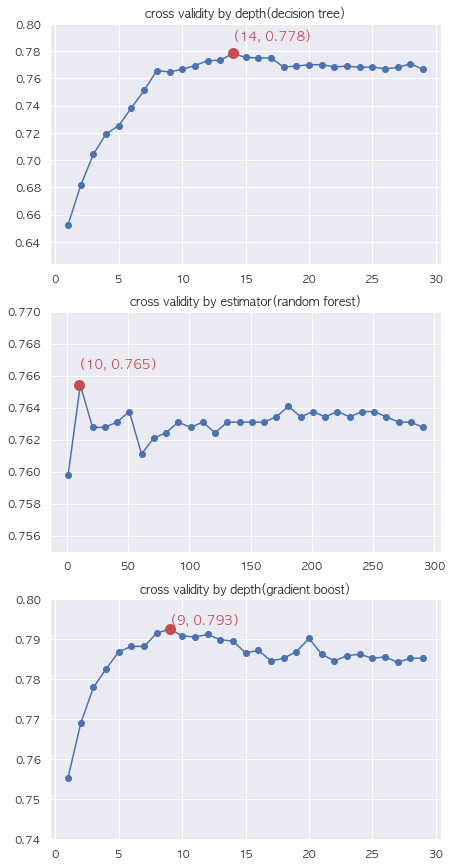

In [61]:
plt.figure(figsize=(7, 15))
plt.subplot(311)
plt.title("cross validity by depth(decision tree)")
plt.plot(range(1, 30), check_tree, "o-")
plt.plot(check_tree.index(max(check_tree))+1, max(check_tree), 'ro', ms=10)
plt.text(check_tree.index(max(check_tree))+1, max(check_tree)+0.009, "({}, {})".format(
    check_tree.index(max(check_tree))+1, round(max(check_tree), 3)), fontdict={"size": 13, "color": "r"})
plt.ylim(0.624,0.8)

plt.subplot(312)
plt.title("cross validity by estimator(random forest)")
plt.plot(range(1, 300, 10), check_ran, "o-")
plt.plot(10, max(check_ran), 'ro', ms=10)
plt.text(10, max(check_ran)+0.001, "({}, {})".format(
    10, round(max(check_ran), 3)), fontdict={"size": 13, "color": "r"})
plt.ylim(0.755,0.770)

plt.subplot(313)
plt.title("cross validity by depth(gradient boost)")
plt.plot(range(1, 30), check_boo, "o-")
plt.plot(check_boo.index(max(check_boo))+1, max(check_boo), 'ro', ms=10)
plt.text(check_boo.index(max(check_boo))+1, max(check_boo)+0.001, "({}, {})".format(
    check_boo.index(max(check_boo))+1, round(max(check_boo), 3)), fontdict={"size": 13, "color": "r"})
plt.ylim(0.74,0.8)
plt.show

    - 최종 모형 제안

In [62]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lightgbm.LGBMClassifier(n_estimators=100, max_depth=9, random_state=0))])

In [63]:
model_final = clf.fit(X, y)

In [64]:
model_final = clf.fit(X, y)
cv = KFold(5, shuffle=True, random_state=0)
check = cross_val_score(model_final, X, y, scoring="accuracy", cv=cv).mean()
check

0.7925768508451122

In [65]:
fpr, tpr, thresholds = roc_curve(y, model_final.predict_proba(X)[:, 1])

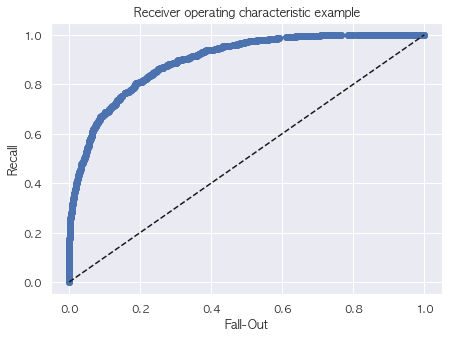

In [90]:
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, 'o-')
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.show()

In [67]:
auc(fpr, tpr)

0.8960518053186345

    - 특성 중요도

In [70]:
def prepeoces_extratree(wconcept_df):
    X_category = wconcept_df.iloc[:, 0:3]
    X_numeric = wconcept_df.iloc[:, 3:4]
    enc = OneHotEncoder(handle_unknown='ignore')
    stan = StandardScaler()
    X_enc = enc.fit(X_category)
    X_stan = stan.fit(X_numeric)
    X_dummy = X_enc.transform(X_category).toarray()
    X_standard = X_stan.transform(X_numeric)
    X2 = np.hstack([X_dummy, X_standard])
    y2 = np.array(wconcept_df.iloc[:, -2:-1])
    y2 = y2.reshape(1, len(y))
    y2 = y2[0]
    return X2, y2, X_enc, X_stan

In [71]:
X2, y2, X_enc, X_stan = prepeoces_extratree(wconcept_df)

In [72]:
forest = ExtraTreesClassifier(n_estimators=10, random_state=0)
forest.fit(X2, y2)
importances = forest.feature_importances_

In [73]:
X_dummy_name = X_enc.categories_
X_standard_name = np.array("sale_prices")

In [74]:
X_name = np.hstack([X_dummy_name[0], X_dummy_name[1],
                    X_dummy_name[2], X_standard_name])

In [75]:
idx = np.argsort(importances)

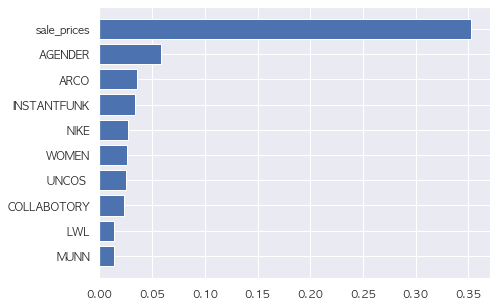

In [79]:
plt.figure(figsize=(7, 5))
plt.barh(X_name[idx][-10:], importances[idx][-10:])
plt.show()

### test

In [80]:
X_enc.categories_

[array(['BEAUTY', 'LIFE', 'MEN', 'WOMEN'], dtype=object),
 array(['ANKLE BOOTS', 'ANKLETS', 'ATHLETICS', 'BACKPACK', 'BAGGY',
        'BALL CAP', 'BEANIE', 'BEANIE / BOMBER', 'BELT', 'BERET', 'BLAZER',
        'BLOUSE', 'BOOTCUT', 'BOY FRIEND', 'BRACELETS', 'BROOCH/PENDANT',
        'BUKET', 'Bottom', 'CAP', 'CARD CASE', 'CARDIGAN', 'CASHMERE',
        'CHINO', 'CLUTCH', 'CLUTCHES', 'COAT', 'CROPPED', 'CROSS BAG',
        'DENIM', 'EARRINGS', 'ECOBAG', 'FABRIC WATCH', 'FASHION ACC',
        'FLARE', 'FLIP-FLOP', 'GLOVES', 'GRAPHIC TEE', 'HAIR ACC',
        'HIGHTOP', 'HOODIE', 'JACKET', 'JEWERLY', 'JUMPER', 'JUMPERS',
        'JUMPSUIT', 'KEY RING', 'LACE-UP', 'LEATHER', 'LEATHER JACKET',
        'LEATHER WATCH', 'LEGGINGS', 'LONG SKIRT', 'LONG-SLEEVE SHIRTS',
        'LONG-SLEEVE TEE', 'LOWTOP', 'MAXIS', 'MESSENGER',
        'METALLIC WATCH', 'MIDDLE-LENGTH SKIRT', 'MINI SKIRT', 'MINIS',
        'MUFFLERS', 'NECKLACE', 'PADDING', 'PEDORA / BERET', 'POUCH',
        'PULLOVER', 'RINGS',

In [81]:
wconcept_df.head(1)

,gender,products,brands,sale_prices,stars,count
0,LIFE,양말,POSITIVE.V,14400,1,1


In [82]:
X

,gender,products,brands,sale_prices
0,LIFE,양말,POSITIVE.V,14400
1,LIFE,양말,POSITIVE.V,12800
2,LIFE,양말,POSITIVE.V,8900
3,LIFE,양말,POSITIVE.V,12800
4,LIFE,양말,POSITIVE.V,12800
...,...,...,...,...
3786,MEN,LOWTOP,FEIYUE,29000
3787,MEN,LOWTOP,FEIYUE,59000
3788,MEN,LOWTOP,FEIYUE,39000
3789,MEN,LOWTOP,FEIYUE,79000


In [83]:
model_final.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
test = [{"gender": "MEN", "products": "CAP",
         "brands": "DEVIWEAR", "sale_prices": "40000"}]
test = pd.DataFrame(test)

In [85]:
test

,gender,products,brands,sale_prices
0,MEN,CAP,DEVIWEAR,40000


In [86]:
model_final.predict(test)

array([0])